# Task3: Vision Transformers for End-to-End Particle Identification with the CMS Experiment
* Datasets:Same as in Task 1

* Description: 
    * Train a Transformer model of your choice on the dataset below to achieve the performance closest to your CNN model’s performance in Task 1. 

    * Discuss the resulting performance of the 2 chosen architectures. 


## Setup

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

## Data Preparation

In [2]:
f1 = h5py.File('../input/electron-photon/download', 'r')
f2 = h5py.File('../input/electron-photon/download_1', 'r')

Electron_X = np.array(f1['X'])
Electron_y = np.array(f1['y'])
Parton_X = np.array(f2['X'])
Parton_y = np.array(f2['y'])
print(Electron_X.shape, Electron_y.shape, Parton_X.shape, Parton_y.shape)

All_X = np.concatenate((Electron_X, Parton_X), axis=0)
All_y = np.concatenate((Electron_y, Parton_y), axis=0)
print(All_X.shape, All_y.shape)
# Then, randomly shuffle the data and split data for train, val, test
rand_seed = 12
index = np.random.permutation(len(All_y))
All_X, All_y = All_X[index][:,:,:,0], All_y[index]
print(All_X.shape, All_y.shape)

# clear cache to save memory
del Electron_X, Electron_y, Parton_X, Parton_y

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(All_X, All_y, test_size=0.2, random_state=12)
X_train = X_train.reshape((-1,32,32,1))
X_test = X_test.reshape((-1,32,32,1))
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

del All_X, All_y

(249000, 32, 32, 2) (249000,) (249000, 32, 32, 2) (249000,)
(498000, 32, 32, 2) (498000,)
(498000, 32, 32) (498000,)
(398400, 32, 32, 1) (99600, 32, 32, 1)
(398400,) (99600,)


## Hyperparameters Configuration

In [3]:
num_classes = 1
input_shape = (32, 32, 1)
learning_rate = 0.0015
batch_size = 64
num_epochs = 50
image_size = 32 # size for resize image
patch_size = 8  # size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 1
mlp_head_units = [1024, 512]  # Size of the dense layers of the final classifier

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(X_train)

2022-03-25 13:23:58.526401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 13:23:58.622269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 13:23:58.623332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 13:23:58.626663: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## ViT model from keras code example

In [5]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Model Compiling and Training

In [7]:
model = create_vit_classifier()

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate
)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5),
        keras.metrics.AUC(from_logits=True),
    ],
)

checkpoint_filepath = "saved_model"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_binary_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.2,
    callbacks=[checkpoint_callback],
    shuffle=True,
)

2022-03-25 13:24:15.472032: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1305477120 exceeds 10% of free system memory.
2022-03-25 13:24:16.794315: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1305477120 exceeds 10% of free system memory.


Epoch 1/50
4980/4980 [==============================] - 39s 7ms/step - loss: 0.6379 - binary_accuracy: 0.6087 - auc: 0.6934 - val_loss: 0.5959 - val_binary_accuracy: 0.6479 - val_auc: 0.7509
Epoch 2/50
4980/4980 [==============================] - 36s 7ms/step - loss: 0.6060 - binary_accuracy: 0.6550 - auc: 0.7347 - val_loss: 0.5877 - val_binary_accuracy: 0.6665 - val_auc: 0.7586
Epoch 3/50
4980/4980 [==============================] - 36s 7ms/step - loss: 0.5954 - binary_accuracy: 0.6695 - auc: 0.7468 - val_loss: 0.5785 - val_binary_accuracy: 0.6770 - val_auc: 0.7667
Epoch 4/50
4980/4980 [==============================] - 36s 7ms/step - loss: 0.5885 - binary_accuracy: 0.6769 - auc: 0.7548 - val_loss: 0.5727 - val_binary_accuracy: 0.7033 - val_auc: 0.7742
Epoch 5/50
4980/4980 [==============================] - 37s 7ms/step - loss: 0.5853 - binary_accuracy: 0.6801 - auc: 0.7578 - val_loss: 0.5794 - val_binary_accuracy: 0.6966 - val_auc: 0.7758
Epoch 6/50
4980/4980 [=======================

In [8]:
!ls

__notebook__.ipynb  saved_model.data-00000-of-00001
checkpoint	    saved_model.index


In [9]:
model.load_weights(checkpoint_filepath)
_, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")
print(f"Test AUC: {auc}")

3113/3113 [==============================] - 18s 5ms/step - loss: 0.5560 - binary_accuracy: 0.7229 - auc: 0.7942
Test accuracy: 0.7228614687919617
Test AUC: 0.7942342162132263


## Plot Training Process

dict_keys(['loss', 'binary_accuracy', 'auc', 'val_loss', 'val_binary_accuracy', 'val_auc'])


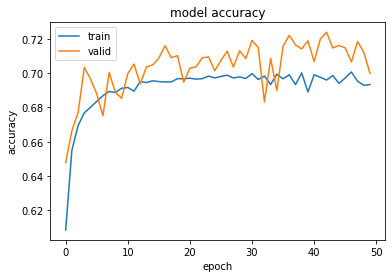

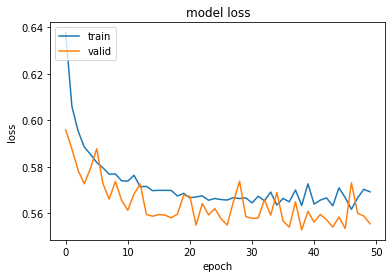

In [10]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 32, 32, 1)    3           input_1[0][0]                    
__________________________________________________________________________________________________
patches (Patches)               (None, None, 64)     0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 16, 64)       5184        patches[0][0]                    
______________________________________________________________________________________________